## Data import and Cleaning

In [35]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

epitopes = pd.read_csv(r'/Users/tariq/Documents/capstone/data/epitope_full_seq.csv')
assays = pd.read_csv(r'/Users/tariq/Documents/capstone/data/tcell_table_export_1740279970.csv')

# make all the column names snake case
epitopes.columns = epitopes.columns.str.lower()
assays.columns = assays.columns.str.lower()

# remove spaces from column names
epitopes.columns = epitopes.columns.str.replace(' ', '')
epitopes.columns = epitopes.columns.str.replace('-', ' ')
epitopes.columns = epitopes.columns.str.replace(' ', '_')

assays.columns = assays.columns.str.replace(' ', '')
assays.columns = assays.columns.str.replace('-', ' ')
assays.columns = assays.columns.str.replace(' ', '_')

epitopes = epitopes.filter(['epitope_objecttype', 'epitope_name', 'fullsequence'])
assays = assays.filter(['epitope_name', 'epitope_moluculeparent', 'host_name', 'host_mhcpresent', 'assay_method','assay_responsemeasured', 'assay_qualitativemeasurement', 'mhcrestriction_name', 'mhcrestriction_class', 'assayantigen_name'])

# map mhc name and class from the assays dataframe to a new column in the epitopes dataframe based on epitope_name
mhc = assays.filter(['epitope_name', 'mhcrestriction_name', 'mhcrestriction_class'])
mhc = mhc.drop_duplicates(subset=['epitope_name'])
epitopes = epitopes.merge(mhc, on='epitope_name', how='left')

/var/folders/5j/4p7c5_1x2fg18bk0nf74_hg40000gn/T/ipykernel_7377/1747643720.py:8: DtypeWarning: Columns (13,14,45,46,47,48,49,54,55,56,57,60,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,105,106,107,108,109,110,111,112,113,115,120,123,128,132,134,135,141,142,143,144,145,149,152) have mixed types. Specify dtype option on import or set low_memory=False.
  assays = pd.read_csv(r'/Users/tariq/Documents/capstone/data/tcell_table_export_1740279970.csv')


In [36]:
epitopes.head()

,epitope_objecttype,epitope_name,fullsequence,mhcrestriction_name,mhcrestriction_class
0,Linear peptide,AAGIGILTV,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A2,I
1,Linear peptide,AAGIGILTVI,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A*02:01,I
2,Linear peptide,ACDPHSGHFV,NaN,HLA-A2,I
3,Linear peptide,ADLVGFLLLK,MSLEQRSLHCKPEEALEAQQEALGLVCVQAATSSSSPLVLGTLEEV...,HLA-A*11:01,I
4,Linear peptide,ADVEFCLSL,MLLAVLYCLLWSFQTSAGHFPRACVSSKNLMEKECCPPWSGDRSPC...,HLA-B*44:03,I


In [37]:
epitopes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28681 entries, 0 to 28680
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   epitope_objecttype    28681 non-null  object
 1   epitope_name          28681 non-null  object
 2   fullsequence          7164 non-null   object
 3   mhcrestriction_name   17613 non-null  object
 4   mhcrestriction_class  17613 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


## Feature Engineering

In [38]:
epitopes['epitope_length'] = epitopes['epitope_name'].str.len()

In [39]:
# Define the function to compute amino acid composition
def compute_composition(peptide):
    total = len(peptide)
    # Calculate frequency for each standard amino acid (you can adjust the list if needed)
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    comp = Counter(peptide)
    # Create a dictionary with relative frequency for each amino acid
    return {aa: comp.get(aa, 0) / total if total != 0 else 0 for aa in amino_acids}

# Apply the function to each epitope
epitope_composition_df = epitopes['epitope_name'].apply(compute_composition).apply(pd.Series)

In [40]:
epitope_composition_df.head()

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.222222,0.000000,0.000000,0.000000,0.000000,0.222222,0.0,0.222222,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111,0.111111,0.0,0.0
1,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.0,0.300000,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.000000,0.100000,0.100000,0.0,0.0
2,0.100000,0.100000,0.100000,0.000000,0.100000,0.100000,0.2,0.000000,0.0,0.000000,0.0,0.0,0.1,0.0,0.0,0.100000,0.000000,0.100000,0.0,0.0
3,0.100000,0.000000,0.100000,0.000000,0.100000,0.100000,0.0,0.000000,0.1,0.400000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.100000,0.0,0.0
4,0.111111,0.111111,0.111111,0.111111,0.111111,0.000000,0.0,0.000000,0.0,0.222222,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.111111,0.0,0.0


In [41]:
# Example DataFrame with a 'peptide' column
df = pd.DataFrame({
    'peptide': ['ACDEFGHIK', 'LMNPQRSTV', 'WYFP']
})

# Kyte-Doolittle hydrophobicity scale
kyte_doolittle = {
    'I': 4.5, 'V': 4.2, 'L': 3.8, 'F': 2.8, 'C': 2.5,
    'M': 1.9, 'A': 1.8, 'G': -0.4, 'T': -0.7, 'S': -0.8,
    'W': -0.9, 'Y': -1.3, 'P': -1.6, 'H': -3.2, 'E': -3.5,
    'Q': -3.5, 'D': -3.5, 'N': -3.5, 'K': -3.9, 'R': -4.5
}

def compute_avg_hydrophobicity(peptide):
    # Get hydrophobicity scores for each amino acid; default to 0 if missing
    scores = [kyte_doolittle.get(aa, 0) for aa in peptide]
    return sum(scores) / len(scores) if scores else 0

# Apply the function to the 'peptide' column to create a new column 'avg_hydro'
epitopes['epitope_avg_hydro'] = epitopes['epitope_name'].apply(compute_avg_hydrophobicity)

In [42]:
epitopes.head()

,epitope_objecttype,epitope_name,fullsequence,mhcrestriction_name,mhcrestriction_class,epitope_length,epitope_avg_hydro
0,Linear peptide,AAGIGILTV,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A2,I,9,2.122222
1,Linear peptide,AAGIGILTVI,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A*02:01,I,10,2.360000
2,Linear peptide,ACDPHSGHFV,NaN,HLA-A2,I,10,-0.140000
3,Linear peptide,ADLVGFLLLK,MSLEQRSLHCKPEEALEAQQEALGLVCVQAATSSSSPLVLGTLEEV...,HLA-A*11:01,I,10,1.620000
4,Linear peptide,ADVEFCLSL,MLLAVLYCLLWSFQTSAGHFPRACVSSKNLMEKECCPPWSGDRSPC...,HLA-B*44:03,I,9,1.233333


## Generation of Negative Samples

In [43]:
def generate_negatives(row):
    epitope = row["epitope_name"]
    full_seq = row["fullsequence"]
    
    # Handle missing or empty sequences
    if pd.isnull(full_seq) or full_seq == "":
        return []
    
    epitope = str(epitope)
    full_seq = str(full_seq)
    ep_len = len(epitope)
    
    negatives = []
    for i in range(len(full_seq) - ep_len + 1):
        window = full_seq[i:i+ep_len]
        if window != epitope:
            negatives.append(window)
    return negatives

# Apply the function to each row

negatives = pd.DataFrame()
negatives['negatives'] = epitopes.apply(generate_negatives, axis=1)
negatives = negatives[["negatives"]].explode("negatives").reset_index(drop=True)
negatives.dropna(subset=["negatives"], inplace=True)
negatives['negatives_length'] = negatives['negatives'].apply(len)
negatives['negatives_avg_hydro'] = negatives['negatives'].apply(compute_avg_hydrophobicity)

In [44]:
#negatives_composition_df = negatives['negatives'].apply(compute_composition).apply(pd.Series)
negatives_composition_df = pd.read_csv("data/negatives_composition_df.csv")

## EDA

### Data Summary

In [45]:
epitopes.head()

,epitope_objecttype,epitope_name,fullsequence,mhcrestriction_name,mhcrestriction_class,epitope_length,epitope_avg_hydro
0,Linear peptide,AAGIGILTV,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A2,I,9,2.122222
1,Linear peptide,AAGIGILTVI,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A*02:01,I,10,2.360000
2,Linear peptide,ACDPHSGHFV,NaN,HLA-A2,I,10,-0.140000
3,Linear peptide,ADLVGFLLLK,MSLEQRSLHCKPEEALEAQQEALGLVCVQAATSSSSPLVLGTLEEV...,HLA-A*11:01,I,10,1.620000
4,Linear peptide,ADVEFCLSL,MLLAVLYCLLWSFQTSAGHFPRACVSSKNLMEKECCPPWSGDRSPC...,HLA-B*44:03,I,9,1.233333


In [46]:
epitope_composition_df.head()

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.222222,0.000000,0.000000,0.000000,0.000000,0.222222,0.0,0.222222,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111,0.111111,0.0,0.0
1,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.0,0.300000,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.000000,0.100000,0.100000,0.0,0.0
2,0.100000,0.100000,0.100000,0.000000,0.100000,0.100000,0.2,0.000000,0.0,0.000000,0.0,0.0,0.1,0.0,0.0,0.100000,0.000000,0.100000,0.0,0.0
3,0.100000,0.000000,0.100000,0.000000,0.100000,0.100000,0.0,0.000000,0.1,0.400000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.100000,0.0,0.0
4,0.111111,0.111111,0.111111,0.111111,0.111111,0.000000,0.0,0.000000,0.0,0.222222,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.111111,0.0,0.0


In [47]:
epitopes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28681 entries, 0 to 28680
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   epitope_objecttype    28681 non-null  object 
 1   epitope_name          28681 non-null  object 
 2   fullsequence          7164 non-null   object 
 3   mhcrestriction_name   17613 non-null  object 
 4   mhcrestriction_class  17613 non-null  object 
 5   epitope_length        28681 non-null  int64  
 6   epitope_avg_hydro     28681 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.5+ MB


In [48]:
epitope_composition_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28681 entries, 0 to 28680
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       28681 non-null  float64
 1   C       28681 non-null  float64
 2   D       28681 non-null  float64
 3   E       28681 non-null  float64
 4   F       28681 non-null  float64
 5   G       28681 non-null  float64
 6   H       28681 non-null  float64
 7   I       28681 non-null  float64
 8   K       28681 non-null  float64
 9   L       28681 non-null  float64
 10  M       28681 non-null  float64
 11  N       28681 non-null  float64
 12  P       28681 non-null  float64
 13  Q       28681 non-null  float64
 14  R       28681 non-null  float64
 15  S       28681 non-null  float64
 16  T       28681 non-null  float64
 17  V       28681 non-null  float64
 18  W       28681 non-null  float64
 19  Y       28681 non-null  float64
dtypes: float64(20)
memory usage: 4.4 MB


### Properties of Epitopes

#### Length

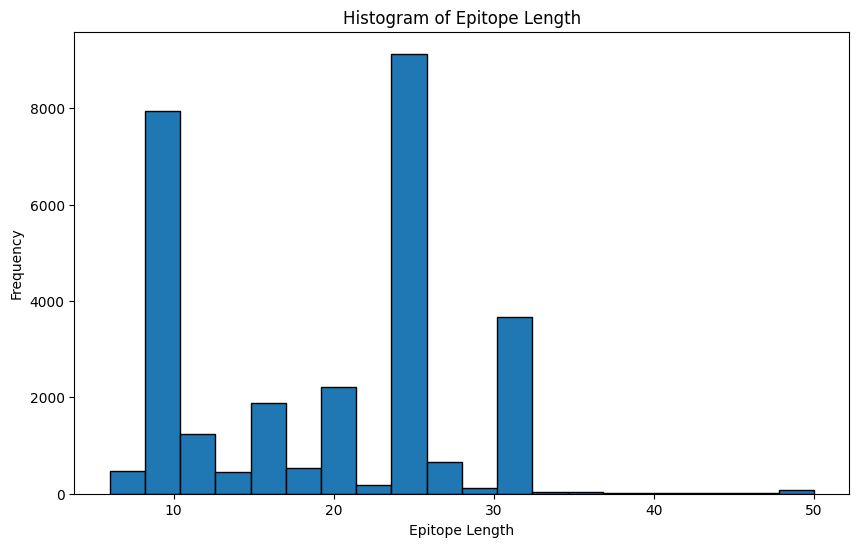

In [49]:
# hist of epitope length
plt.figure(figsize=(10, 6))
plt.hist(epitopes['epitope_length'], bins=20, edgecolor='black')
plt.xlabel('Epitope Length')
plt.ylabel('Frequency')
plt.title('Histogram of Epitope Length')
plt.show()

In [50]:
epitopes['epitope_length'].describe()

count    28681.000000
mean        19.389422
std          8.255925
min          6.000000
25%         10.000000
50%         20.000000
75%         25.000000
max         50.000000
Name: epitope_length, dtype: float64

#### Hydrophobicity

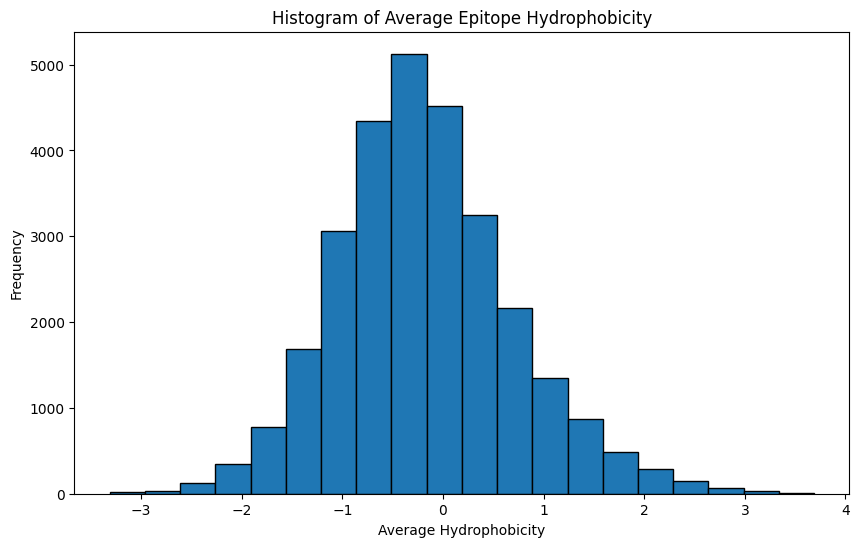

In [51]:
# histogram of average hydrophobicity
plt.figure(figsize=(10, 6))
plt.hist(epitopes['epitope_avg_hydro'], bins=20, edgecolor='black')
plt.xlabel('Average Hydrophobicity')
plt.ylabel('Frequency')
plt.title('Histogram of Average Epitope Hydrophobicity')
plt.show()

In [52]:
epitopes['epitope_avg_hydro'].describe()

count    28681.000000
mean        -0.178410
std          0.883064
min         -3.312000
25%         -0.762500
50%         -0.240000
75%          0.333333
max          3.688889
Name: epitope_avg_hydro, dtype: float64

#### Composition

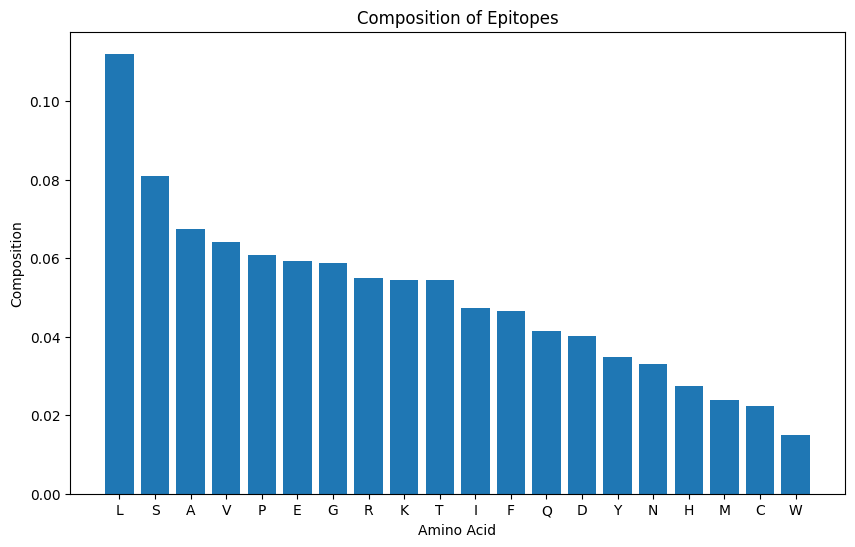

In [53]:
# plot the composition of the epitopes, sort by the composition of the amino acids
# Calculate mean composition and sort
mean_composition = epitope_composition_df.mean().sort_values(ascending=False)

# Plot the sorted composition
plt.figure(figsize=(10, 6))
plt.bar(mean_composition.index, mean_composition.values)
plt.xlabel('Amino Acid')
plt.ylabel('Composition')
plt.title('Composition of Epitopes')
plt.show()

#### n-gram frequency analysis

/var/folders/5j/4p7c5_1x2fg18bk0nf74_hg40000gn/T/ipykernel_7377/3954531820.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ngram', y='count', data=top_ngram, palette="viridis")


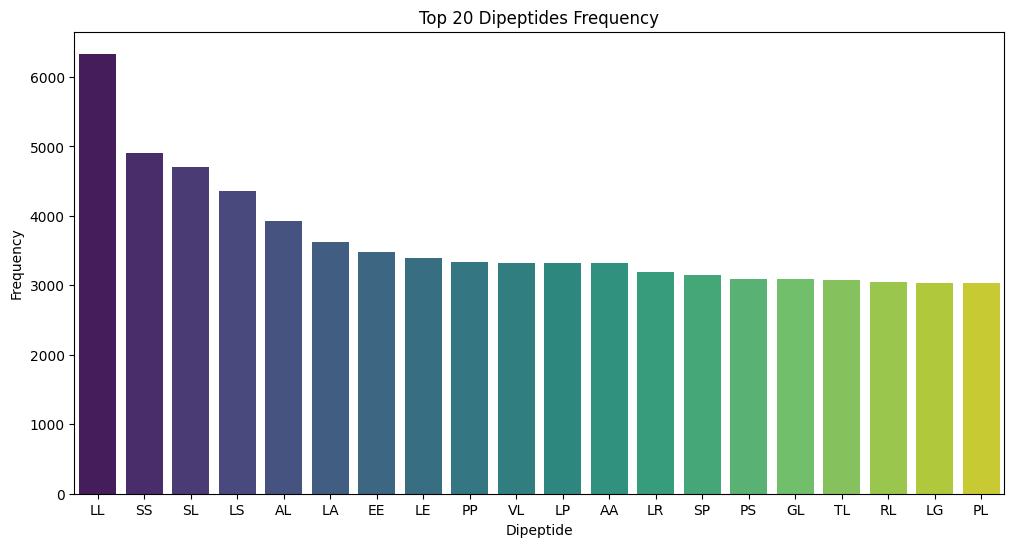

In [54]:
def ngram_frequency(peptides, n=2):
    ngrams = []
    for peptide in peptides:
        if len(peptide) < n:
            continue
        for i in range(len(peptide) - n + 1):
            ngram = peptide[i:i+n]
            ngrams.append(ngram)
    return Counter(ngrams)

dipeptide_freq = ngram_frequency(epitopes['epitope_name'], n=2)

df_ngram = pd.DataFrame(dipeptide_freq.items(), columns=['ngram', 'count'])
df_ngram = df_ngram.sort_values('count', ascending=False)

top_n = 20
top_ngram = df_ngram.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x='ngram', y='count', data=top_ngram, palette="viridis")
plt.title(f"Top {top_n} Dipeptides Frequency")
plt.xlabel("Dipeptide")
plt.ylabel("Frequency")
plt.show()

### Properties of negative samples

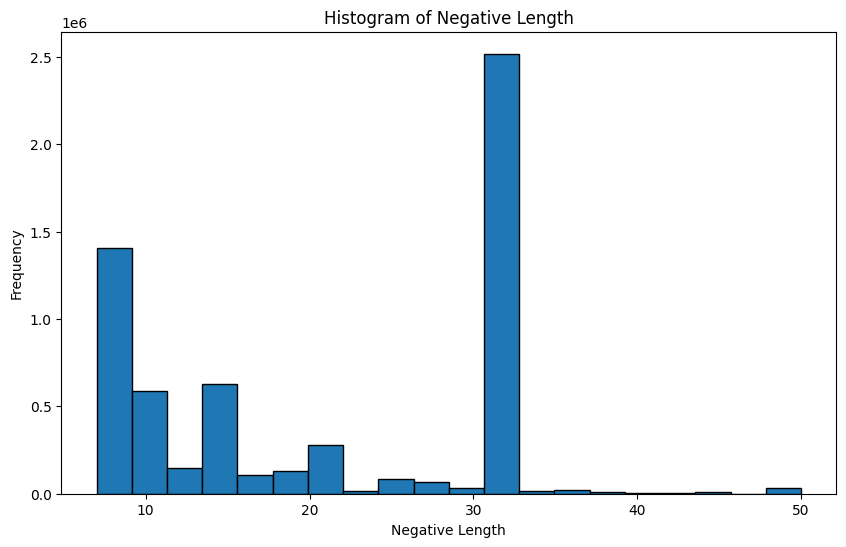

In [55]:
# hist of negative length
plt.figure(figsize=(10, 6))
plt.hist(negatives['negatives_length'], bins=20, edgecolor='black')
plt.xlabel('Negative Length')
plt.ylabel('Frequency')
plt.title('Histogram of Negative Length')
plt.show()

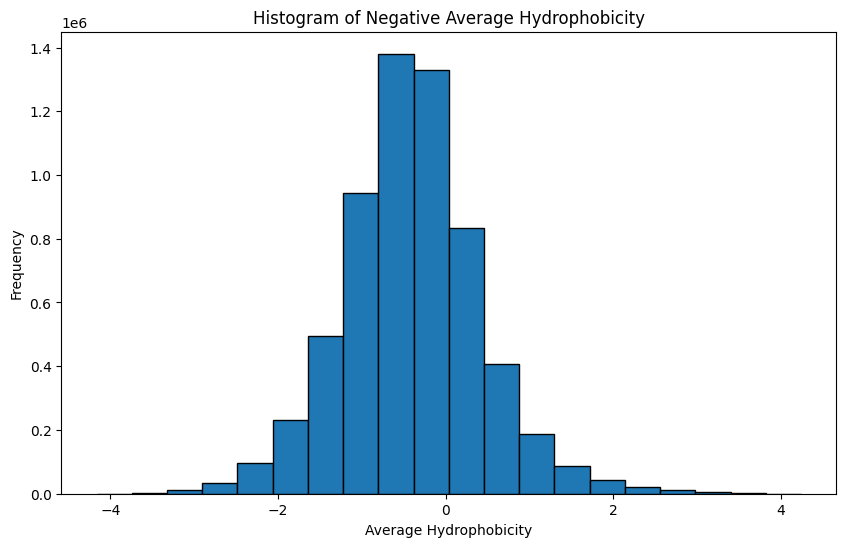

In [56]:
# histogram of average hydrophobicity
plt.figure(figsize=(10, 6))
plt.hist(negatives['negatives_avg_hydro'], bins=20, edgecolor='black')
plt.xlabel('Average Hydrophobicity')
plt.ylabel('Frequency')
plt.title('Histogram of Negative Average Hydrophobicity')
plt.show()

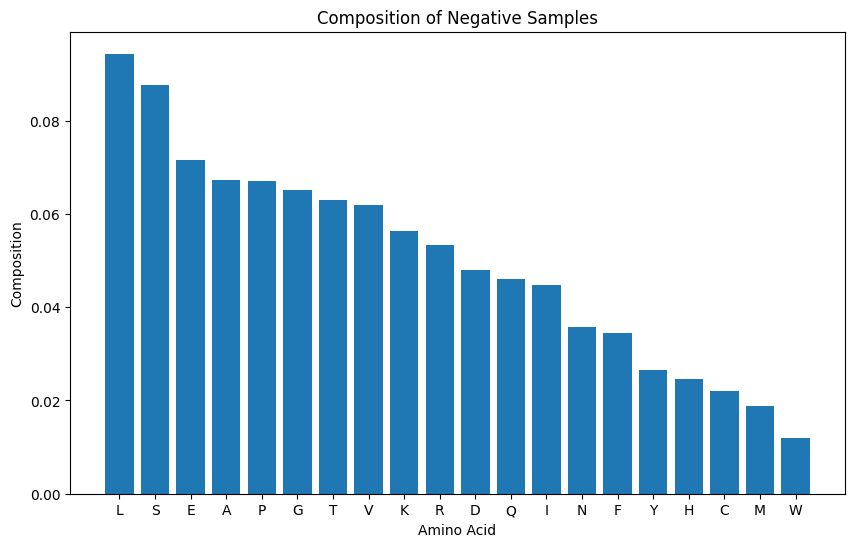

In [57]:
# plot the composition of the negatives, sort by the composition of the amino acids
# Calculate mean composition and sort
mean_composition = negatives_composition_df.mean().sort_values(ascending=False)

# Plot the sorted composition
plt.figure(figsize=(10, 6))
plt.bar(mean_composition.index, mean_composition.values)
plt.xlabel('Amino Acid')
plt.ylabel('Composition')
plt.title('Composition of Negative Samples')
plt.show()

In [58]:
print(5)


5
